# High Value Customer Identification

# 0.0 Planejamento da Solução (IOT)

## Input - Entrada

### Problema de Negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )

## Output - Saída

1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [96]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import inflection
import re
import umap as umap

from matplotlib import pyplot as plt 
from plotly import express as px
from IPython.display import HTML
# from ydata_profiling import ProfileReportperformance
import sweetviz as sv

from sklearn import cluster as c
from sklearn import metrics 

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

### Set Display

In [97]:
def jupyter_settings():
    %matplotlib inline
    
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

## 0.2 Load Data

In [98]:
# load data
df_raw = pd.read_excel('../data/raw/Online Retail.xlsx')
# df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode-escape')
# df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [99]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [100]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [101]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore( x ) # function to snakecase
cols_news = list( map( snakecase, cols_old ))
df1.columns = cols_news

## 1.2 Data Dimentions

In [102]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    541909 non-null  object        
 1   stock_code    541909 non-null  object        
 2   description   540455 non-null  object        
 3   quantity      541909 non-null  int64         
 4   invoice_date  541909 non-null  datetime64[ns]
 5   unit_price    541909 non-null  float64       
 6   customer_id   406829 non-null  float64       
 7   country       541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [103]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 1.3 Check NA

In [104]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [105]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
df_missing = df1[df1['customer_id'].isna()]
print(f'Missing: {df_missing.shape[0]}')
print(f'Not Missing: {df1.shape[0]}')

Missing: 0
Not Missing: 406829


In [106]:
# replace Na
# create reference
backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
backup['customer_id'] = np.arange(19000, 19000+len(backup), 1)

# merge original data frame
df1 = pd.merge(df1, backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [107]:
df1[df1['invoice_no'] == 536365]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850.0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,United Kingdom,17850.0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,United Kingdom,17850.0


## 1.5 Change dtypes

In [108]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850


In [16]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.6 Descriptive Stats

In [109]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.6.1 Numerical Attributes

In [110]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


In [19]:
# df1[df1['unit_price'] < 0.01].sort_values('unit_price', ascending=False).head(50)

#### 1.6.2 Categorical Att

##### Invoice No

In [111]:
# problema: Temos invoice com letras e numeros

df1['invoice_no'] = df1['invoice_no'].astype(str)  # Convert to string if not already

df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]

df_letter_invoices.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom,17548


In [21]:
print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 8905
Total number of negative quantity: 8905


##### Stock Code

In [22]:
# check stock codes only characters
# df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
df1['stock_code'] = df1['stock_code'].astype(str)  # Convert to string if not already

unique_alpha_stock_codes = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()


# Acão:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

In [23]:
unique_alpha_stock_codes

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

#### Description

In [24]:
df1.head()

# Acão: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850


#### Country

In [25]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

# 2.0 Data Filtering

In [115]:
df2 = df1.copy()

In [116]:
# === Numerical attributes ====
df2_purchases = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL','PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [117]:
df3 = df2_purchases.copy()

## 3.1 Feature Creation

In [118]:
# DF reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

1. peso para compras mais recorrente
    - ultima
    - penultima .shift(1)
    - antepenultima compras .shift(2)

2. qtde_invoices
3. qtde_items
4. qtde_produtos
5. Avg_ticket
6. avg_recency_days
7. frequency
8. number of returns
9. basket size
10. unique basket size
11. Groos revenue return
12. proporção de retorno sobre compra


### Gross Revenue OK 

In [119]:
# Gross revenue
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

/tmp/ipykernel_83702/1522764053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


### Recency - Days since the last purchase OK

In [120]:
# Recency - Last day purchase
# **inverter função**
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
# df_recency['recency_days'] = df_recency['recency_days'].apply( lambda x: 1 / x if x != 0 else 0)
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

### Quantity of purchases OK


In [121]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
dtype: int64

### Total of items purchased

In [122]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
dtype: int64

### Totoal of unique products purchased

In [123]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
qtde_products    0
dtype: int64

### Avg Ticket OK

In [124]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
qtde_products    0
avg_ticket       0
dtype: int64

### Avg recency days

In [125]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=False )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else 0, axis=1 )
# df_aux['avg_recency_days'] = df_aux['avg_recency_days'].apply( lambda x: 1/x if x !=0 else 0)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
dtype: int64

### Frequency of purchases
- frequency = event / time 

In [126]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
frequency           0
dtype: int64

### Number of returns OK

In [127]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
frequency           0
qtde_returns        0
dtype: int64

### Basket Size

In [128]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
frequency           0
qtde_returns        0
avg_basket_size     0
dtype: int64

### Unique Basket Size

In [129]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

In [130]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,371,34,1733,297,18.152222,-3.000000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56,9,1390,171,18.904035,-22.333333,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2,15,5028,232,28.902500,-22.352941,0.040431,50.0,335.200000,7.600000
3,13748,948.25,95,5,439,28,33.866071,-70.000000,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333,3,80,3,292.000000,-7.666667,0.073171,22.0,26.666667,0.333333


# 4.0 EDA

In [131]:
df4 = df_ref.copy()
df4 = df4.dropna()

## 4.1 Univariate Analysis

**Metricas para olharmos**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range ( Dispersão )
    - Média e Mediana
    - Desvio Padrão e Variância.
    - Coeficiente de Variação ( CV )
    - Distribuição

In [43]:
# sweeviz
report = sv.analyze(df4)
report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 4.2 Bivariate Analysis

In [44]:
# df42 = df4.drop(columns=['customer_id'], axis=1)
# sns.pairplot(df42)

## 4.3 Estudo de espaços

In [132]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [133]:
from sklearn import preprocessing as pp

In [134]:
# Scaler

mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform( df43[['recency_days']])
df43['qtde_invoices'] = mm.fit_transform( df43[['qtde_invoices']])

df43['qtde_items'] = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket'] = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days'] = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform( df43[['frequency']])
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']])

df43['avg_basket_size'] = mm.fit_transform( df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']])


In [135]:
X = df43.copy()

### 4.3.1 PCA

In [136]:
from sklearn import decomposition as dd

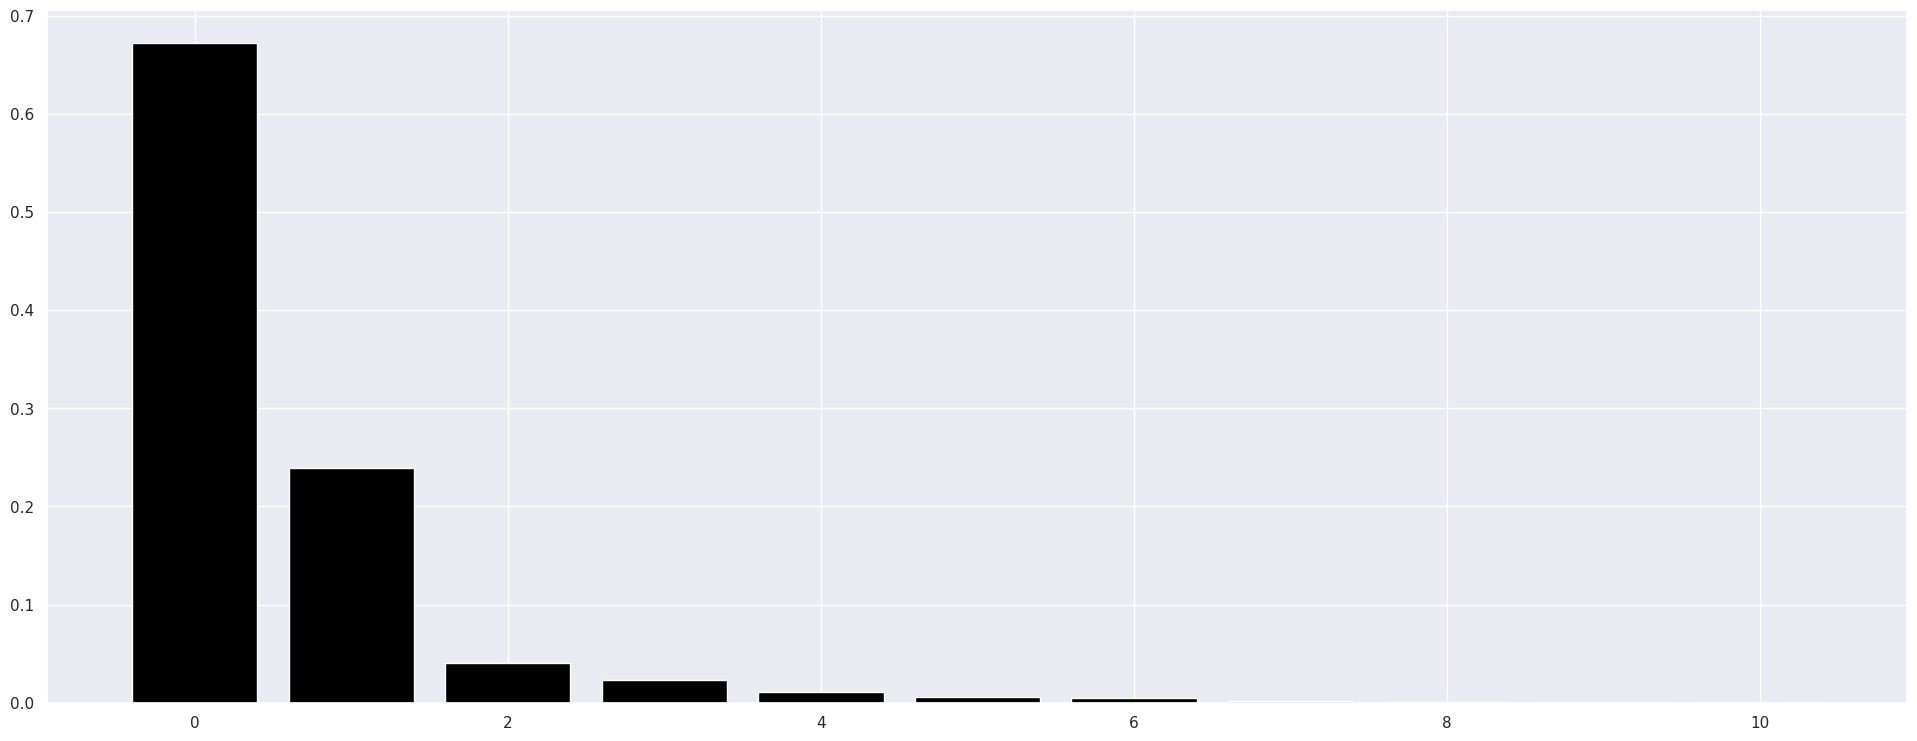

In [137]:
pca = dd.PCA( n_components=X.shape[1] )

principal_component = pca.fit_transform(X)

features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_component )

<Axes: xlabel='0', ylabel='1'>

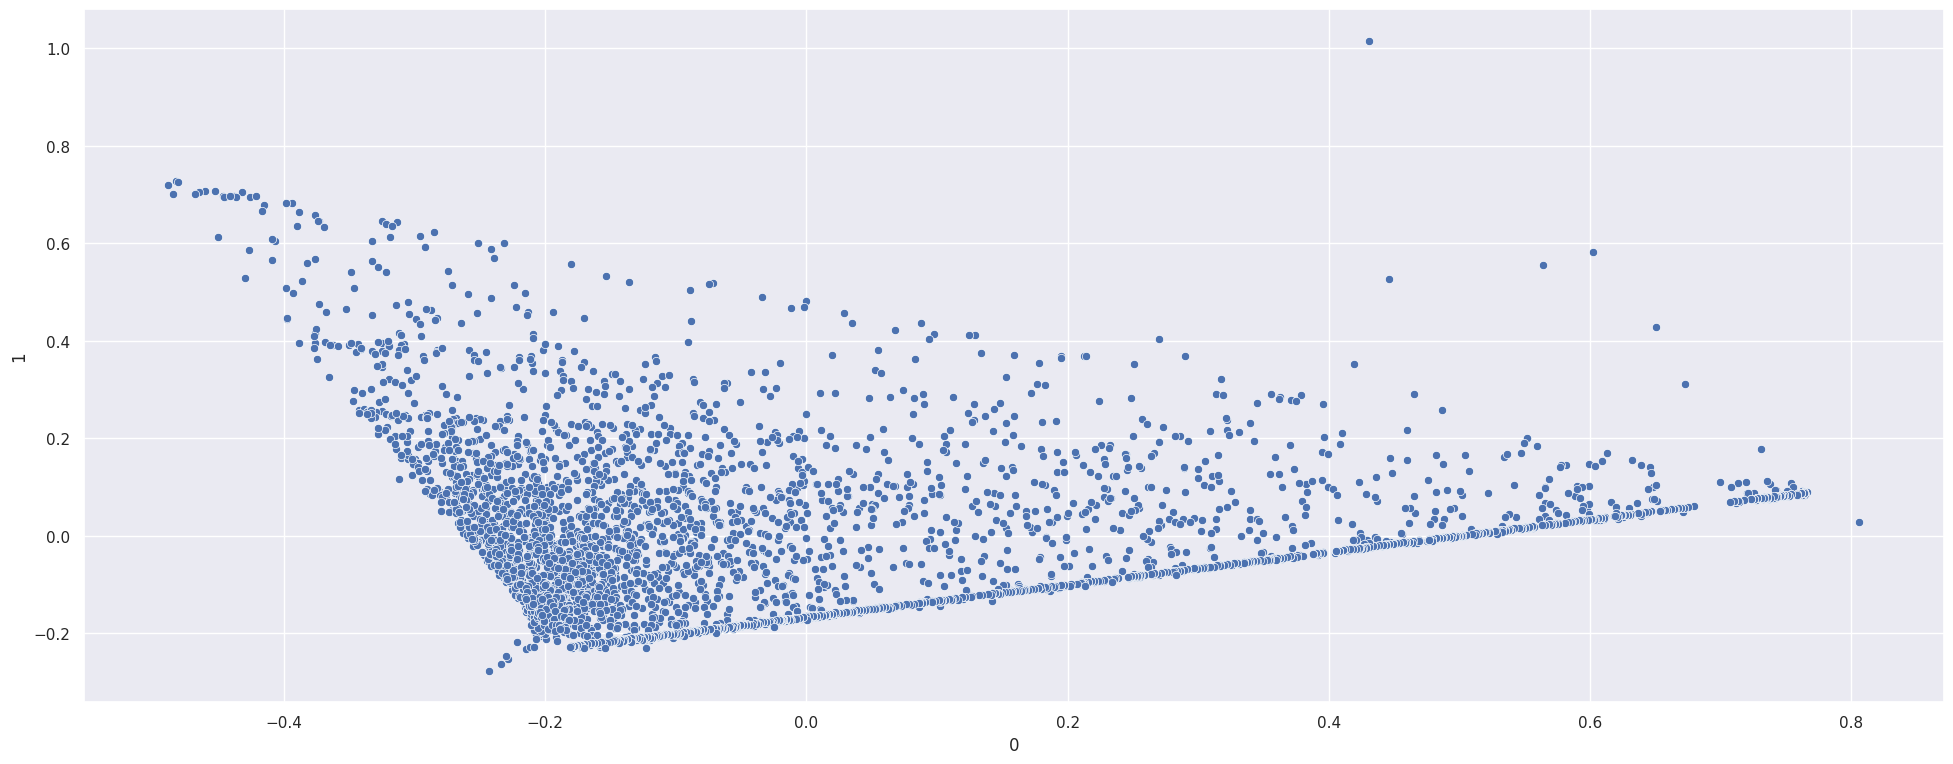

In [138]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 UMAP

/home/natan/miniconda3/envs/clusterenv/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

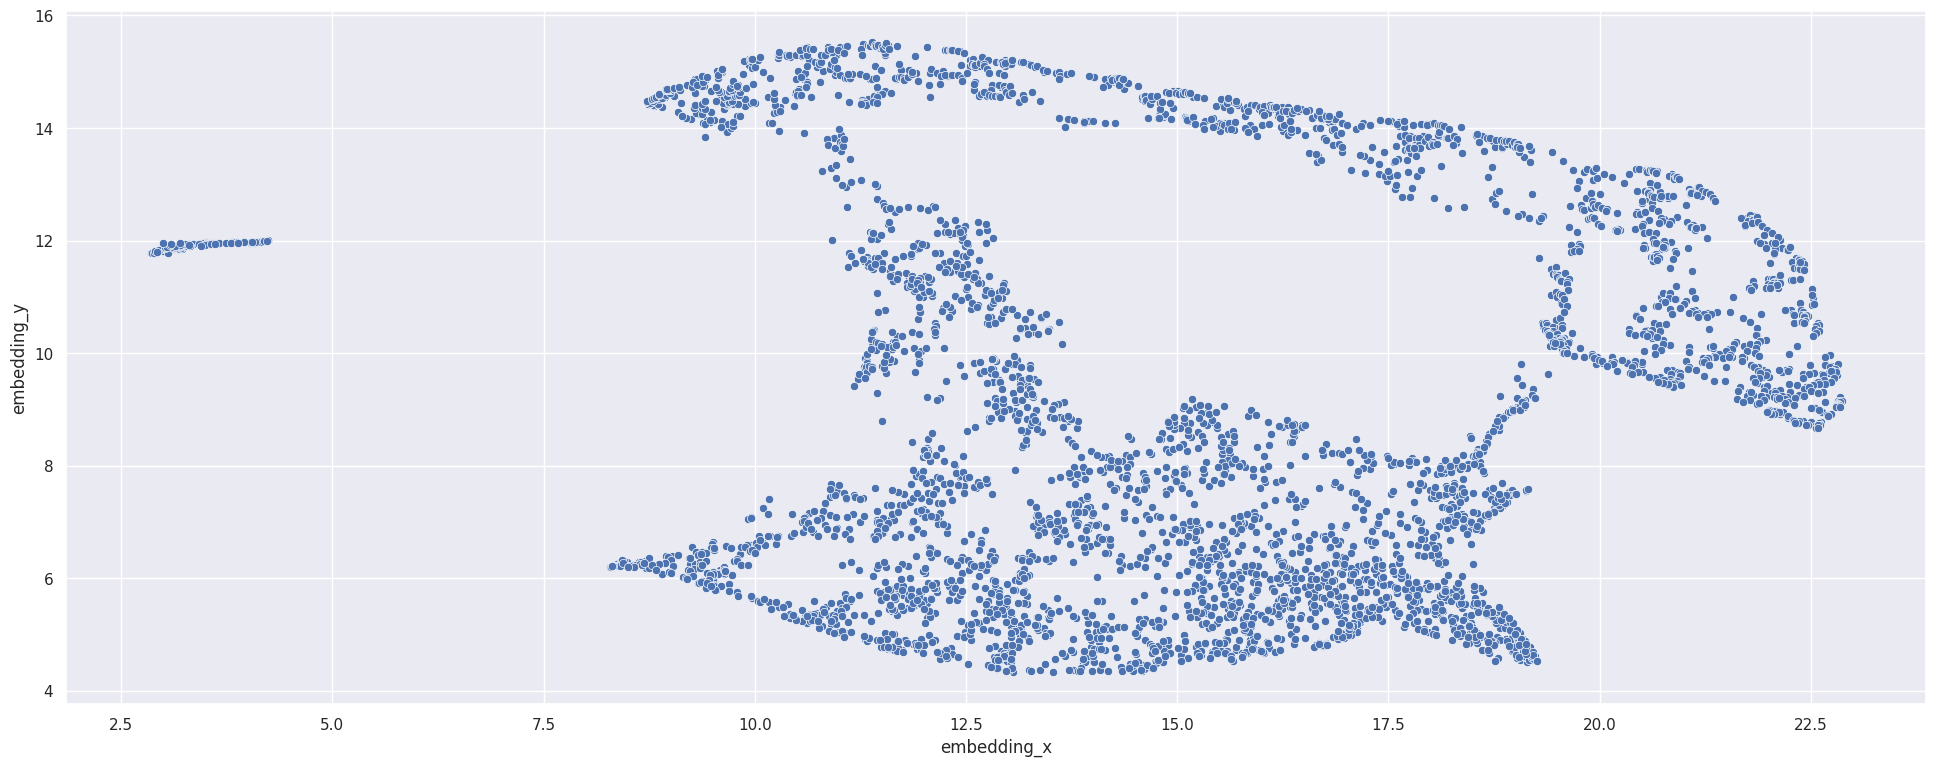

In [139]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_umap)

### 4.3.3 t-SNE

In [140]:
from sklearn import manifold as mn

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

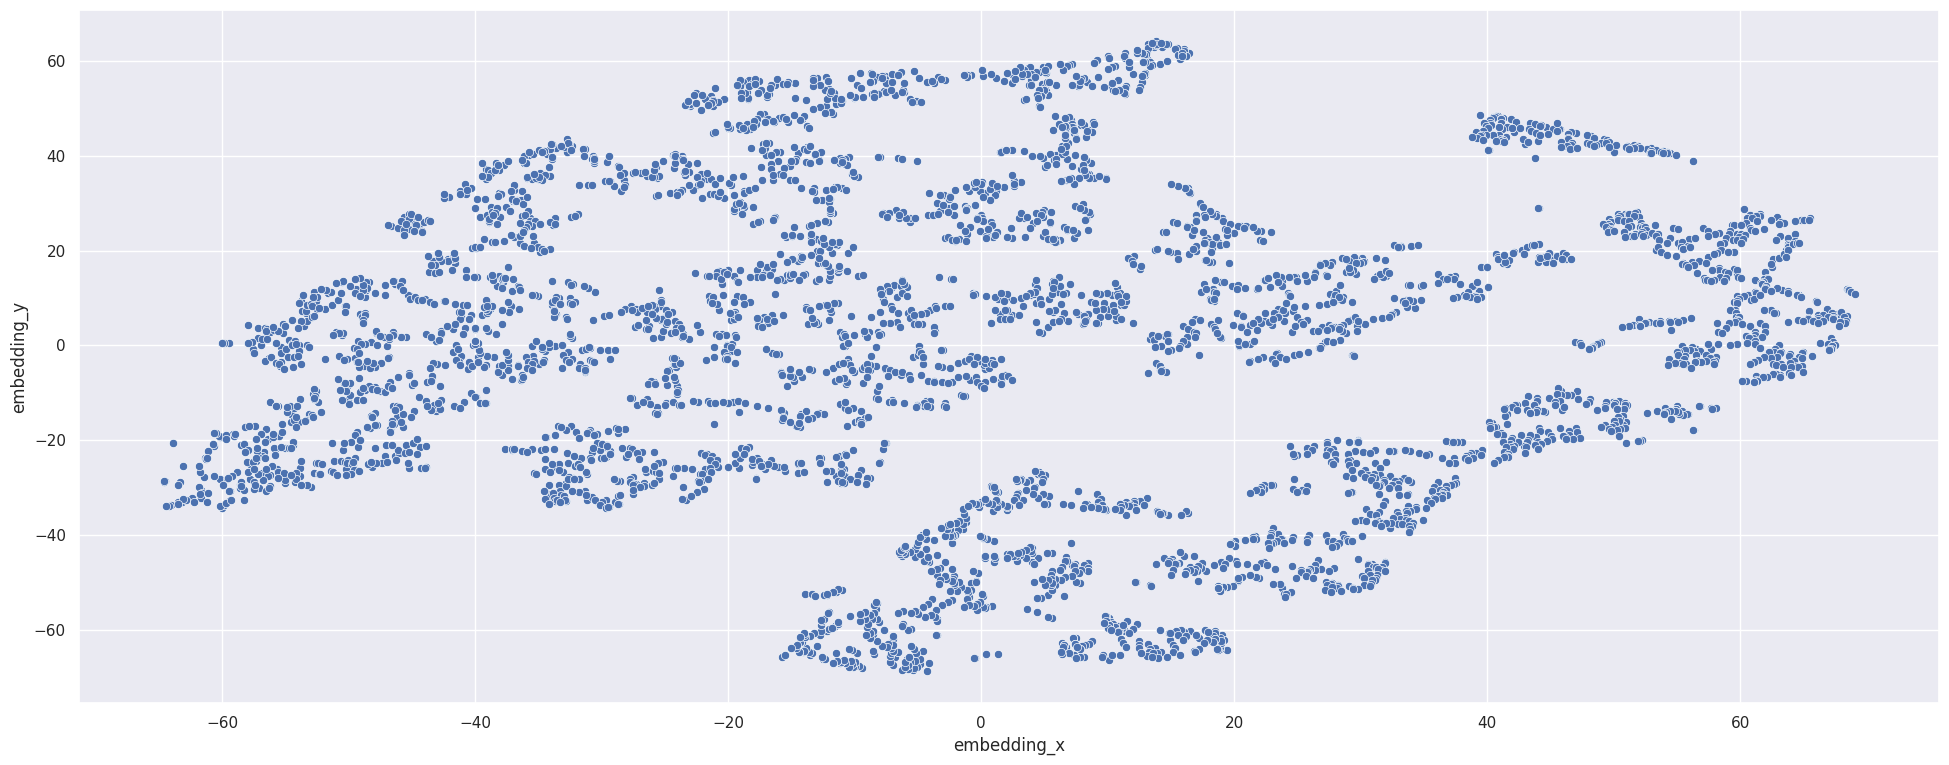

In [141]:
reducer = mn.TSNE( n_components=2, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_umap)

### 4.3.4 Tree-based Embedding

In [142]:
from sklearn import ensemble as en

In [143]:
X = df43.drop(columns=['gross_revenue'], axis=1).copy()
y = df43['gross_revenue'].copy()

# model definiton
forest = en.RandomForestRegressor( n_estimators=100, 
                                  random_state=42,
                                   criterion='friedman_mse' )

# model training
forest.fit( X, y )

# predict
df_leaf = pd.DataFrame(forest.apply( X ))

/home/natan/miniconda3/envs/clusterenv/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

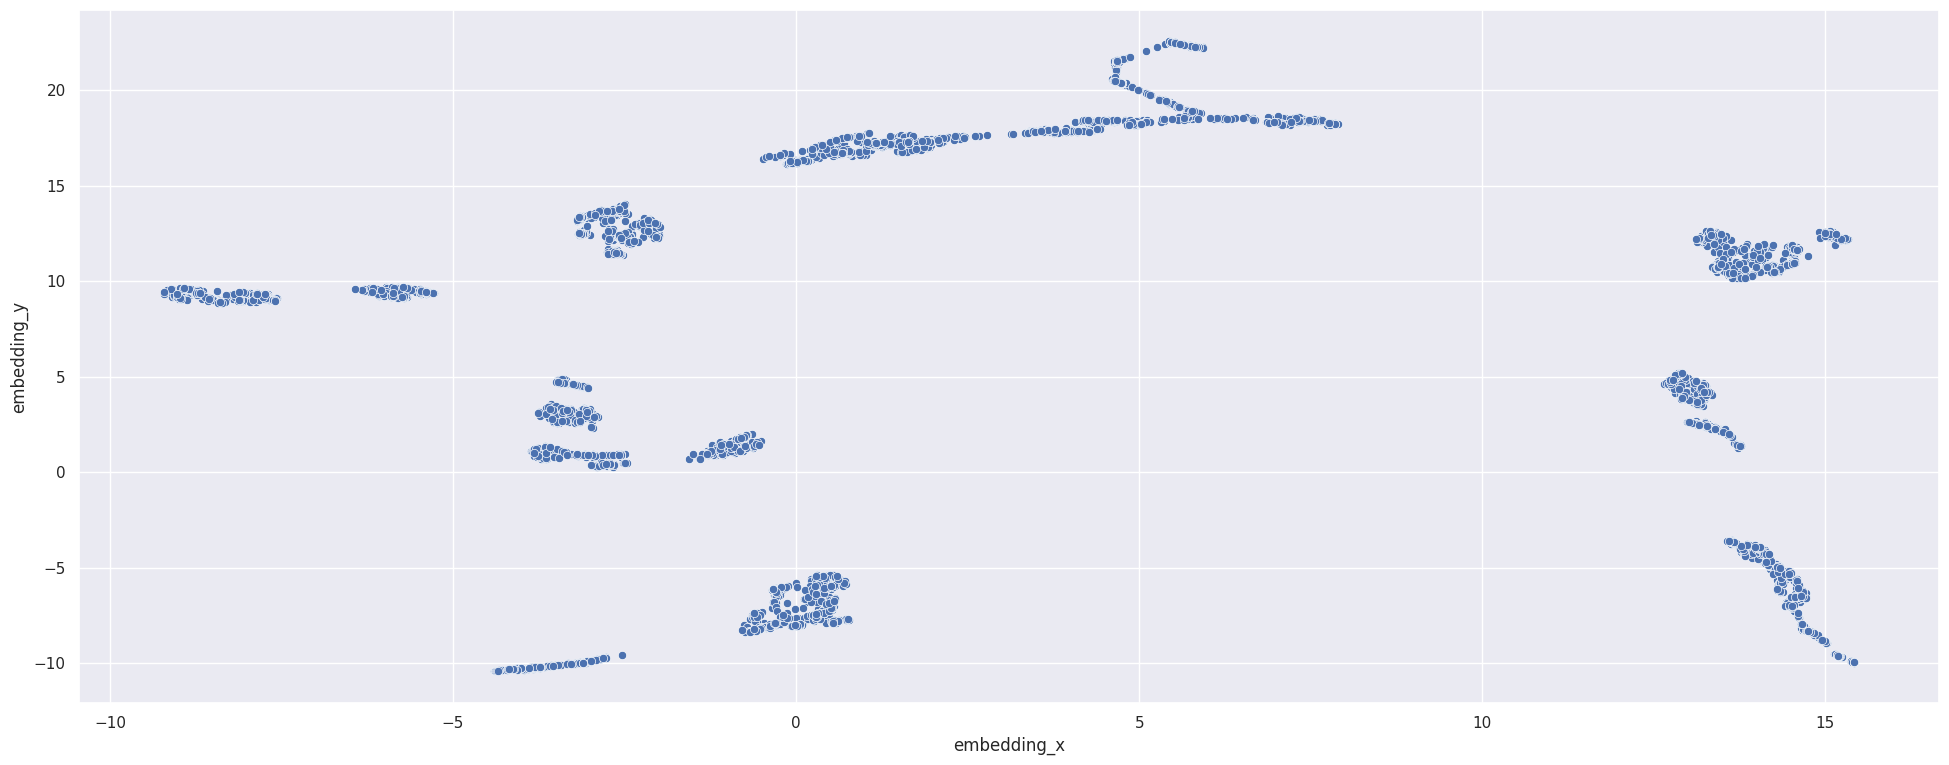

In [144]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tree)

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

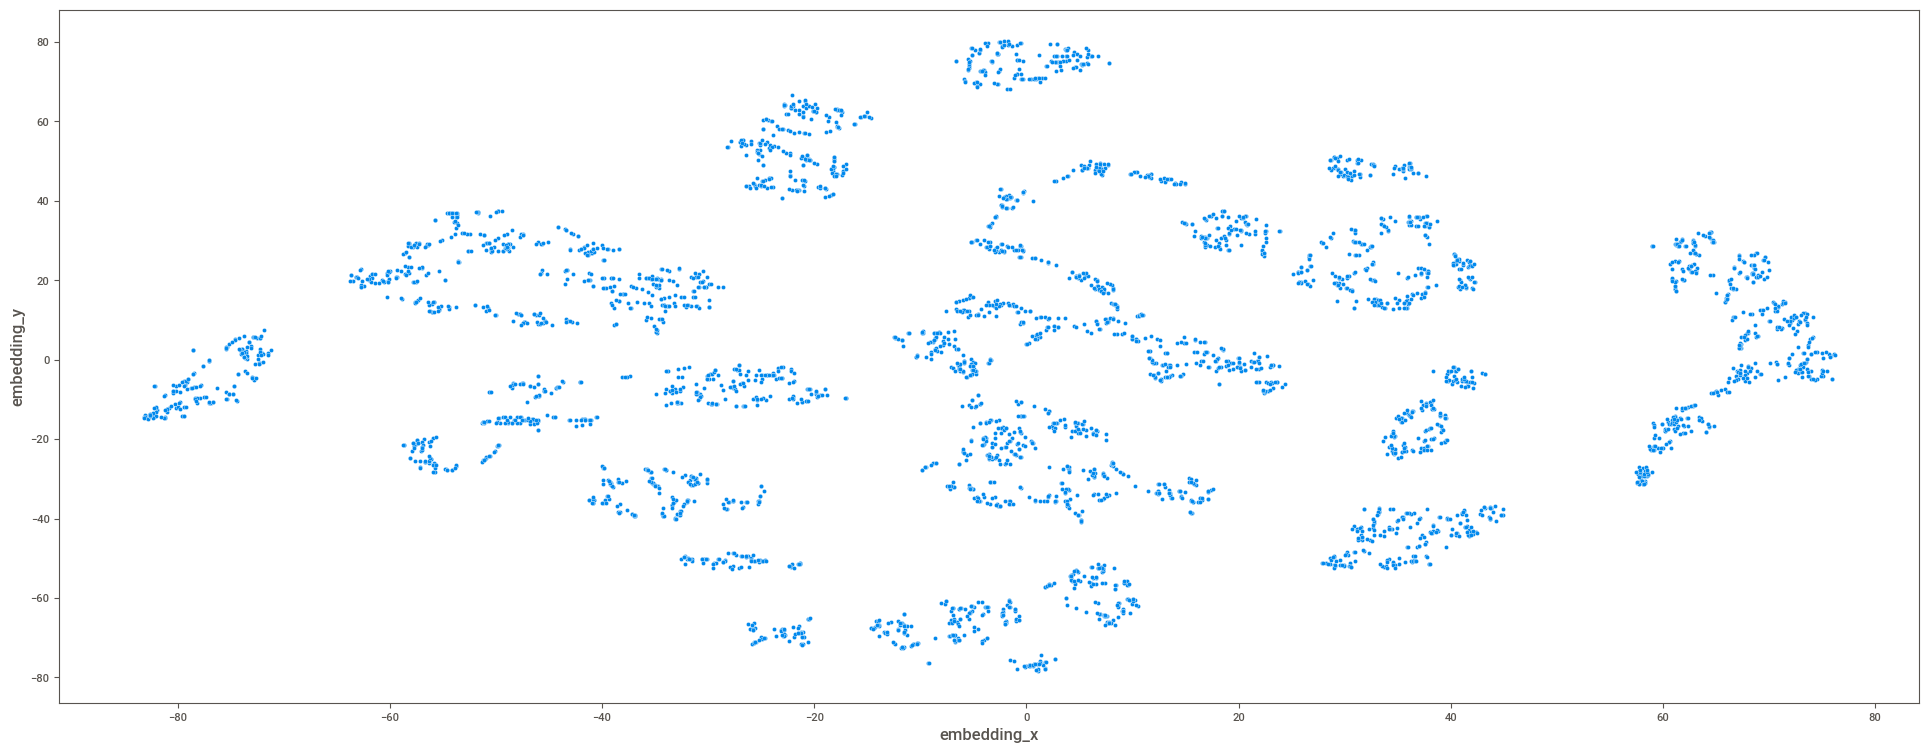

In [59]:
reducer = mn.TSNE( n_components=2, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                data=df_tsne)

# 5.0 Data Preparation

In [145]:
df5 = df4.copy()

# 6.0 Feature Selection

In [146]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

Em problemas de clusterização, o número de clusters precisa ser fornecido ao algoritmo previamente. Por isso primeiro fazemos o fine-tunning para encontrar o número ideal de clusters.

In [147]:
# X = df6.drop( columns=['customer_id'])
X = df_tree.copy()

In [148]:
clusters = np.arange(2, 30, 1)

## 7.1 K-Means

In [149]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k , n_init=10)

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = metrics.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

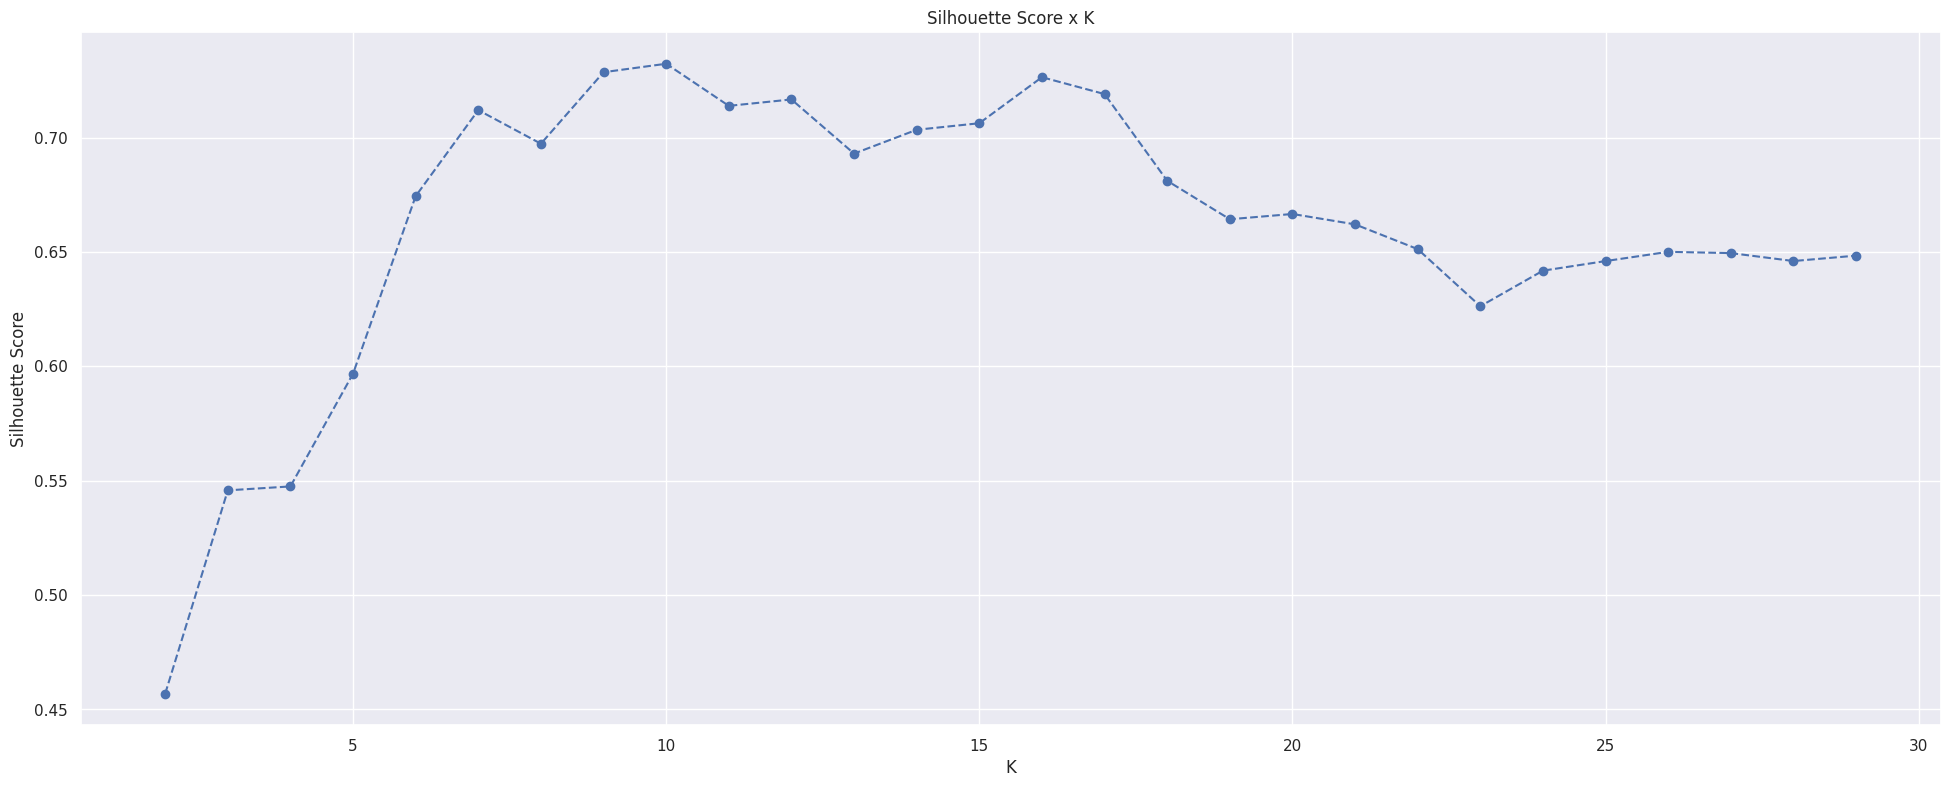

In [150]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2 GMM

In [151]:
from sklearn.mixture import GaussianMixture

In [152]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = metrics.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

FloatingPointError: underflow encountered in exp

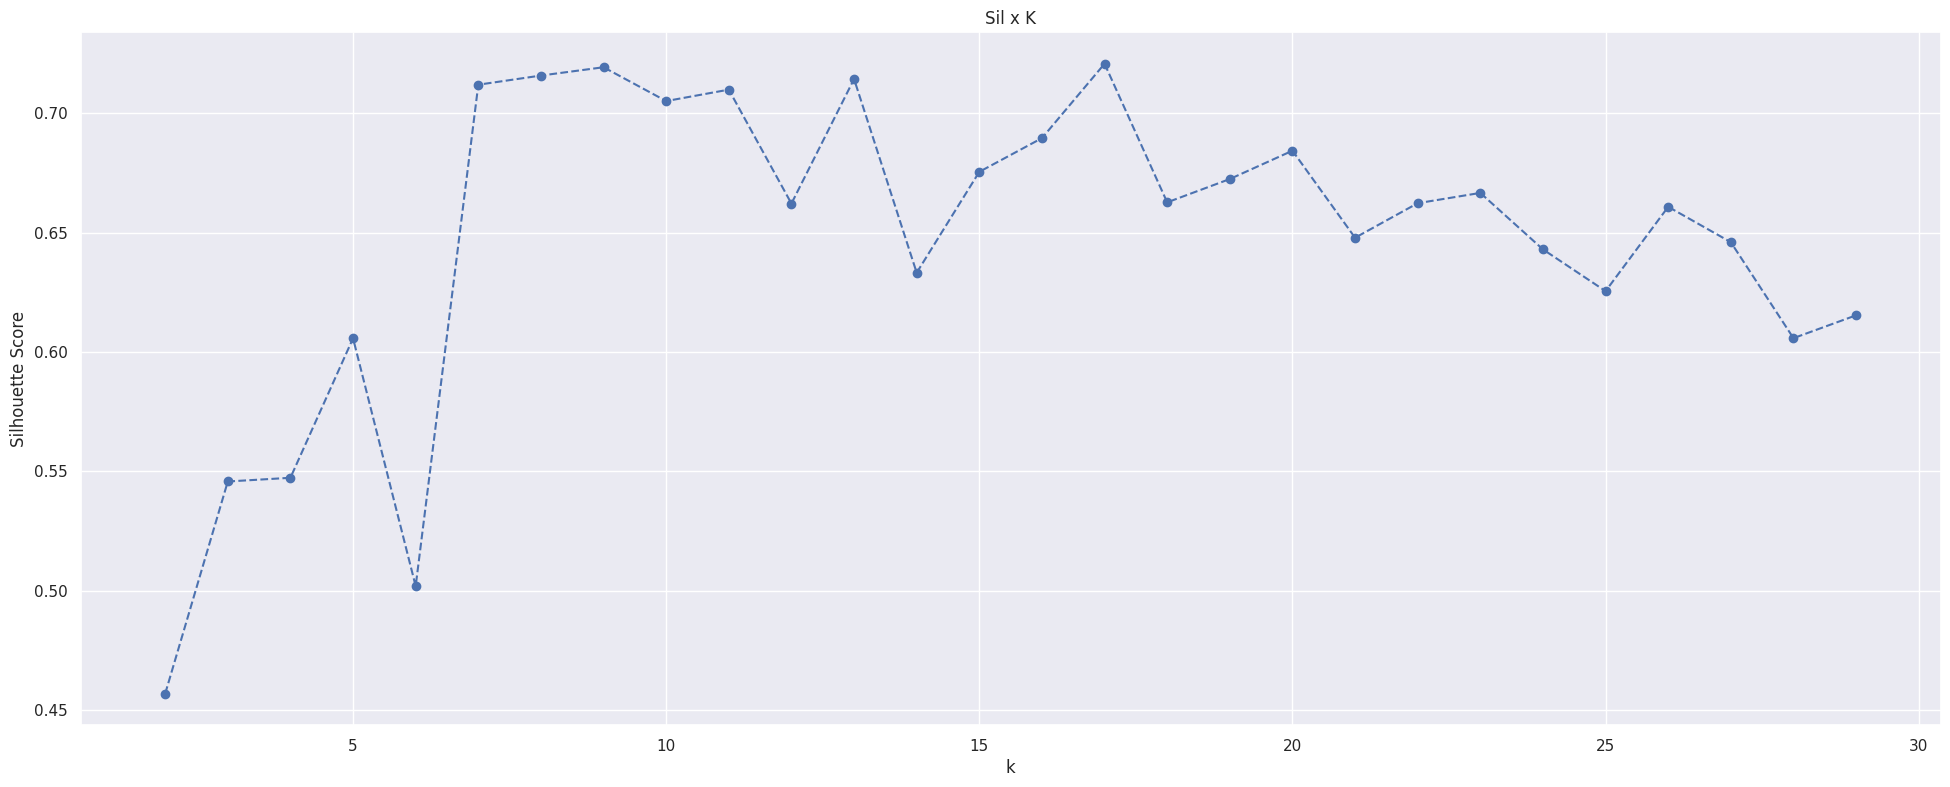

In [ ]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering

In [153]:
from scipy.cluster import hierarchy as hc

In [154]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

In [155]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = metrics.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

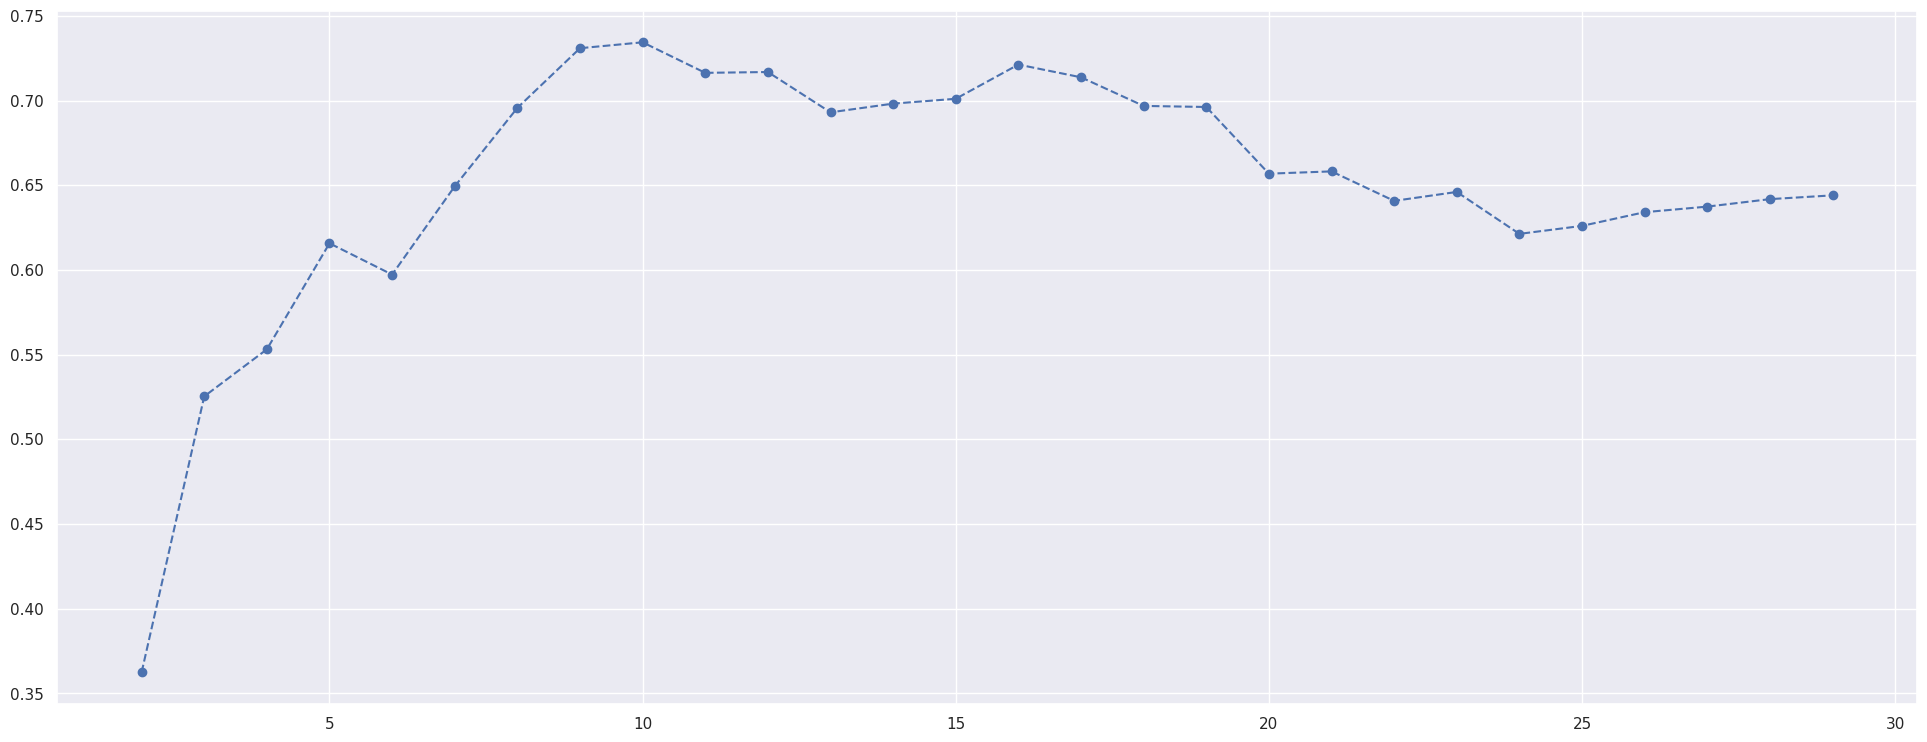

In [156]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4 DBSCAN

In [157]:
from sklearn.neighbors import NearestNeighbors

In [158]:
eps=2.0
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = metrics.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels ) ) ) )
print( np.unique( labels ) )

Silhouette Score: 0.7193167209625244
Number of Clusters: 9
[0 1 2 3 4 5 6 7 8]


## 7.5 Results

In [ ]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [ ]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
KMeans,0.456857,0.545778,0.547491,0.596783,0.674397,0.711997,0.706008,0.728572,0.733646,0.713415,0.716797,0.692994,0.695840,0.702122,0.694545,0.719008,0.702161,0.662626,0.675747,0.662006,0.648199,0.655798,0.671248,0.648991,0.642297,0.649031,0.646408,0.649050
GMM,0.456857,0.545778,0.547330,0.605776,0.501939,0.711997,0.715835,0.719317,0.705142,0.709932,0.662202,0.714383,0.633230,0.675506,0.689617,0.720778,0.662715,0.672485,0.684351,0.647890,0.662356,0.666671,0.643010,0.625521,0.660848,0.646031,0.605819,0.615394
HC,0.362477,0.525371,0.553151,0.615738,0.597273,0.649377,0.695673,0.730915,0.734397,0.716370,0.716857,0.693054,0.698199,0.701055,0.721248,0.713739,0.696844,0.696214,0.656849,0.658191,0.640788,0.646058,0.621302,0.626025,0.634109,0.637402,0.641811,0.644038


## 7.1 Within-Cluster Sum of Square (WSS)

In [ ]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, n_init=20, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score

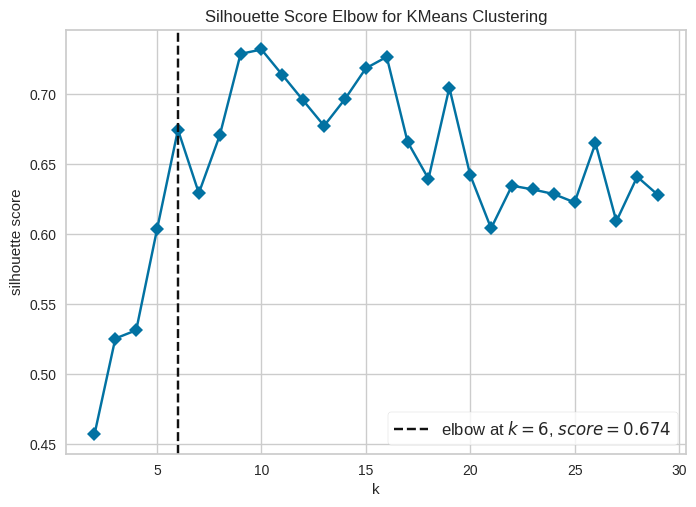

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False, n_init=10 )
kmeans.fit( X )
kmeans.show()

## 7.3 Silhouette Analysis

### 7.3.2 Silhouette True

In [ ]:
fig, ax = plt.subplots( 4, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# 8.0 Model Training

## 8.1 K-Means

In [169]:
# Model definition
k = 10
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, random_state=42, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

In [165]:
# # model definition & training
# hc_model = hc.linkage( X, 'ward' )

# # model predict
# labels = hc.fcluster( hc_model, k, criterion='maxclust' )

## 8.2 Cluster Validation

In [161]:
# WSS (Within-cluster sum of square)
print(kmeans.inertia_)

# SS (Silhouette Score)
print(metrics.silhouette_score( X, labels, metric='euclidean'))

10983.681640625


0.6995869


# 9.0 Cluster Analyslis

In [171]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,371,34,1733,297,18.152222,-3.000000,17.000000,40.0,50.970588,0.617647,5
1,13047,3232.59,56,9,1390,171,18.904035,-22.333333,0.028302,35.0,154.444444,11.666667,5
2,12583,6705.38,2,15,5028,232,28.902500,-22.352941,0.040431,50.0,335.200000,7.600000,7
3,13748,948.25,95,5,439,28,33.866071,-70.000000,0.017921,0.0,87.800000,4.800000,8
4,15100,876.00,333,3,80,3,292.000000,-7.666667,0.073171,22.0,26.666667,0.333333,9


In [167]:
X['cluster'] = labels

## 9.1 Visualization Inspection

### 3D inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

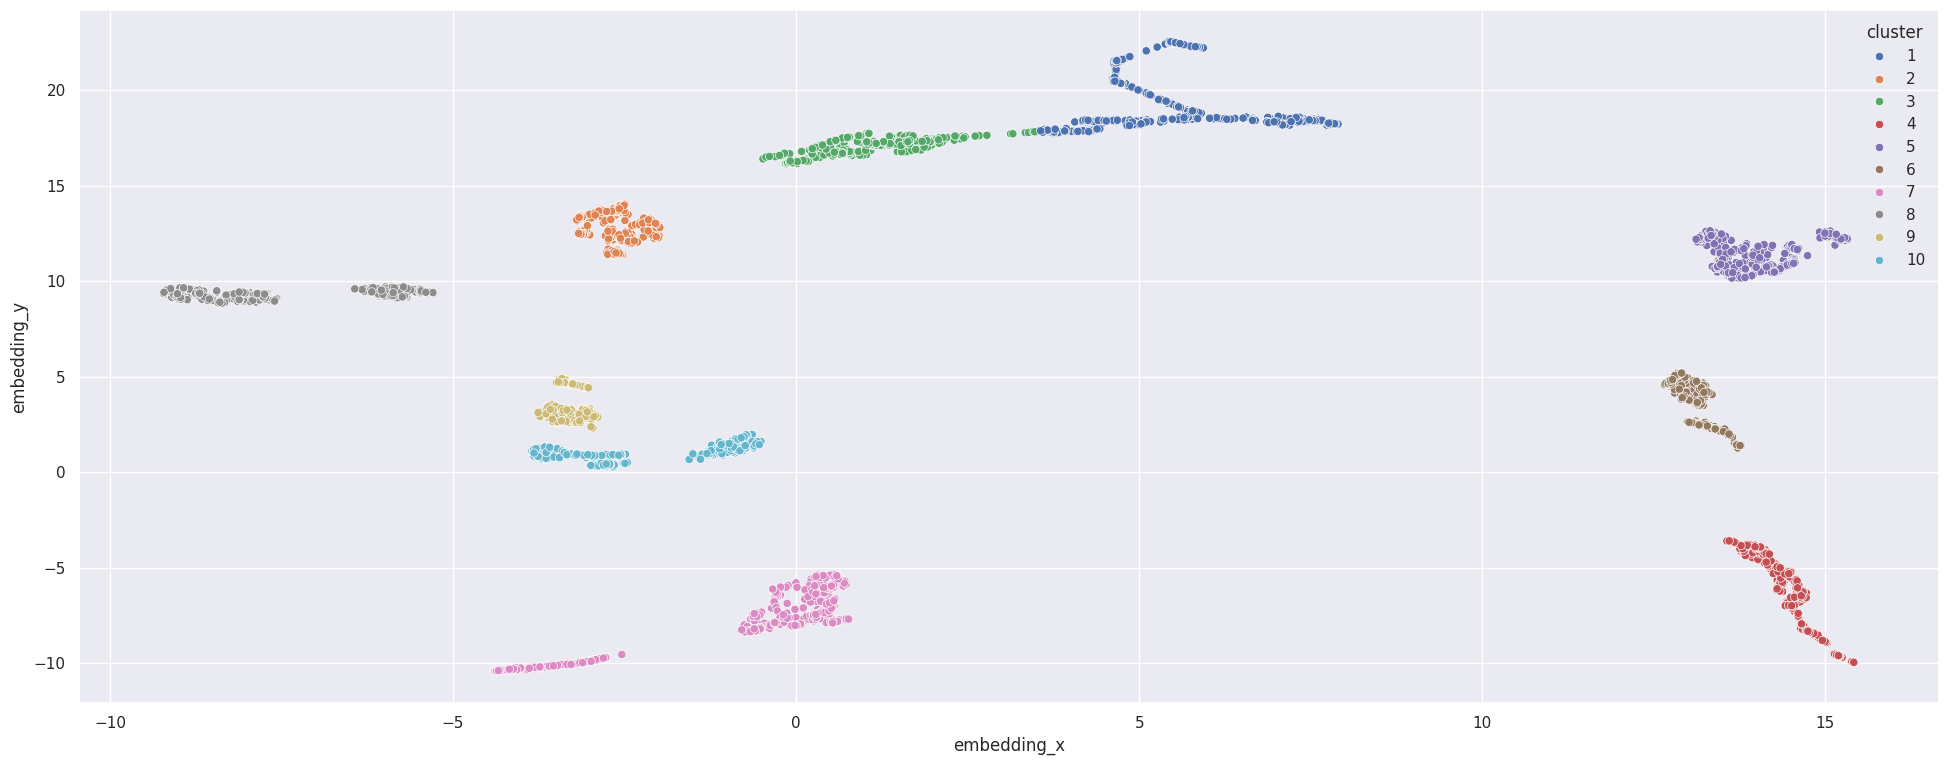

In [168]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette='deep', data=X)

In [ ]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

### 9.1.2 2D plot

In [ ]:
df_viz = df9.drop( columns=['customer_id'], axis=1)
# sns.pairplot( df_viz, hue='cluster')

### 9.1.3 UMAP

- **Manifold Hipothesis**
 - A hipótese postula que dados que aparentam necesitar de uma alta quantidade de variáveis para sua explicabilidade, na verdade podem ser descritos com um número considerávelmente menor de features.
 - PCA, t-SNE, UMAP, Random Forest

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

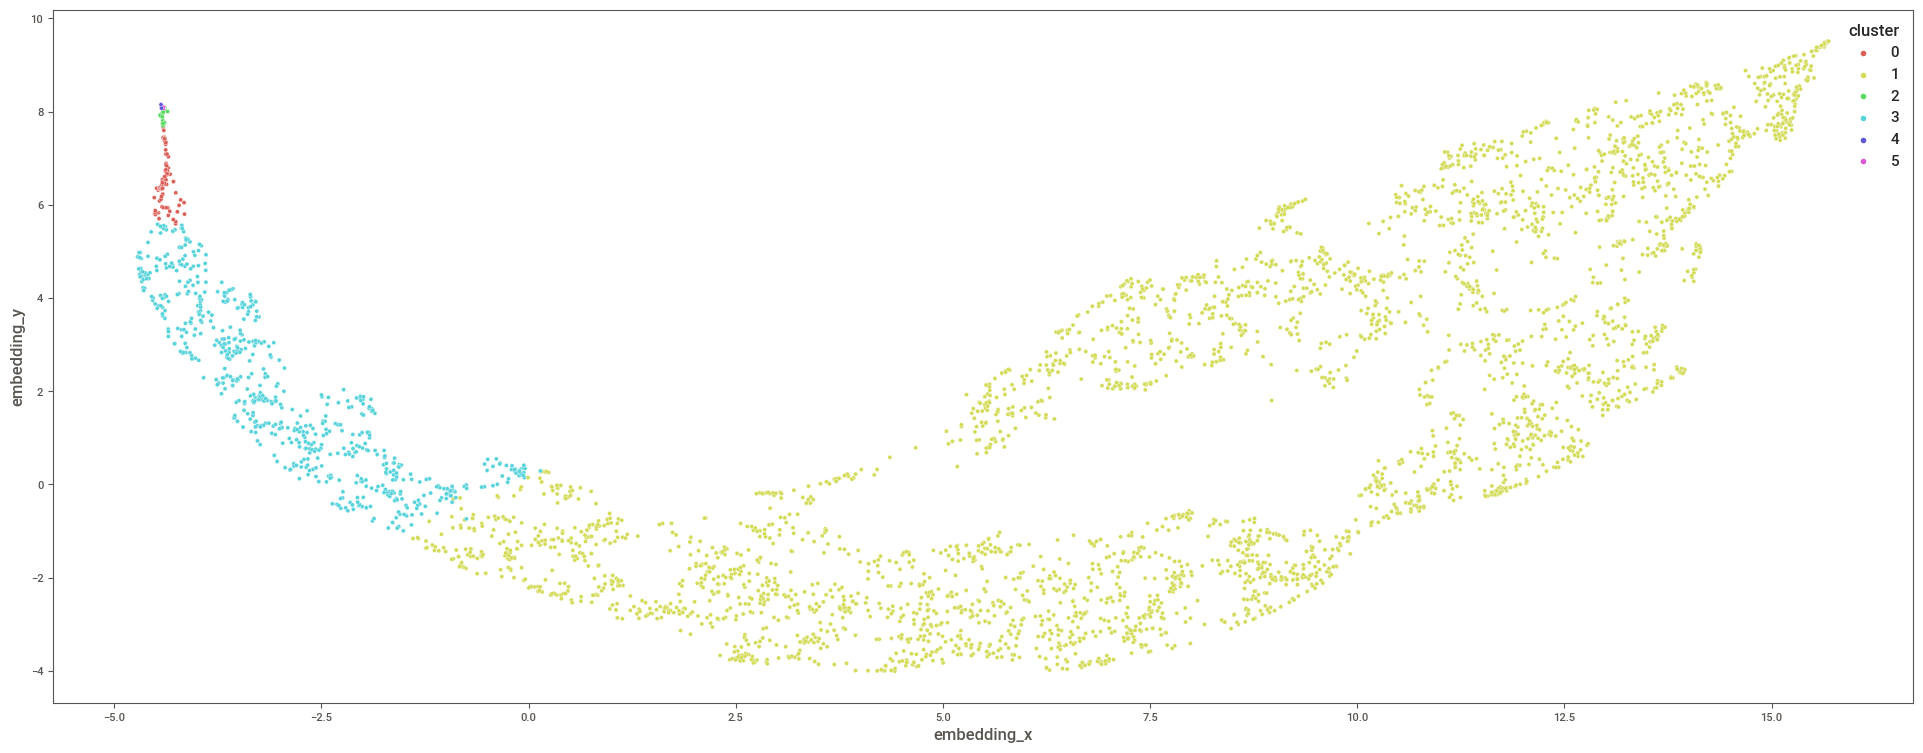

In [ ]:
reducer = umap.UMAP( n_neighbors=30, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', 
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette( 'hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## 9.2 Cluster Profile

In [84]:
# df9['avg_recency_days'] = df9['avg_recency_days'].apply( lambda x: 1/x if x !=0 else 0)
# df9['recency_days'] = df9['recency_days'].apply( lambda x: 1/x if x !=0 else 0)

In [172]:
df9.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,371,34,1733,297,18.152222,-3.000000,17.000000,40.0,50.970588,0.617647,5
1,13047,3232.59,56,9,1390,171,18.904035,-22.333333,0.028302,35.0,154.444444,11.666667,5
2,12583,6705.38,2,15,5028,232,28.902500,-22.352941,0.040431,50.0,335.200000,7.600000,7
3,13748,948.25,95,5,439,28,33.866071,-70.000000,0.017921,0.0,87.800000,4.800000,8
4,15100,876.00,333,3,80,3,292.000000,-7.666667,0.073171,22.0,26.666667,0.333333,9


In [175]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['qtde_invoices', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Qnt_items
df_items_no = df9[['qtde_items', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_items_no, how='inner', on='cluster' )

# Avg frequency
df_frequency_no = df9[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency_no, how='inner', on='cluster' )

# Avg returns
df_returns_no = df9[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns_no, how='inner', on='cluster' )

In [176]:
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_invoices,qtde_items,frequency,qtde_returns
7,7,479,11.059801,11225.436701,25.872651,15.181628,6814.043841,0.098949,494.830898
5,5,374,8.635419,2570.682807,41.339572,6.631016,1586.058824,0.107853,22.366310
3,3,445,10.274763,1756.879348,44.058427,5.447191,996.276404,0.075215,20.997753
8,8,602,13.899792,1164.889618,65.014950,3.576412,619.805648,0.172444,10.189369
4,4,404,9.328100,684.676015,94.254950,2.027228,422.113861,0.368370,6.190594
2,2,389,8.981759,555.303316,76.089974,2.838046,262.622108,0.026766,4.066838
1,1,365,8.427615,401.047123,136.076712,1.126027,256.989041,0.995809,3.665753
0,0,381,8.797045,322.561709,129.078740,1.737533,133.217848,0.537492,1.451444
6,6,242,5.587624,290.750744,140.586777,1.099174,163.413223,1.014587,1.838843
9,9,650,15.008081,169.746046,168.864615,1.256923,59.572308,0.874062,1.756923


# 10.0 Deploy

# 11.0 Insert into SQLITE

In [177]:
import sqlite3
from sqlalchemy import create_engine

In [89]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             4331 non-null   int64  
 1   gross_revenue           4331 non-null   float64
 2   recency_days            4331 non-null   float64
 3   qtde_invoices           4331 non-null   int64  
 4   qtde_items              4331 non-null   int64  
 5   qtde_products           4331 non-null   int64  
 6   avg_ticket              4331 non-null   float64
 7   avg_recency_days        4331 non-null   float64
 8   frequency               4331 non-null   float64
 9   qtde_returns            4331 non-null   float64
 10  avg_basket_size         4331 non-null   float64
 11  avg_unique_basket_size  4331 non-null   float64
 12  cluster                 4331 non-null   int32  
dtypes: float64(8), int32(1), int64(4)
memory usage: 423.1 KB


In [178]:
# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
    customer_id       INTEGER,  
    gross_revenue     REAL,
    recency_days      REAL,
    qtde_invoices     INTEGER,  
    qtde_items        INTEGER,  
    qtde_products     INTEGER,  
    avg_ticket        REAL,
    avg_recency_days  REAL,
    frequency         REAL,
    qtde_returns      REAL,
    avg_basket_size   REAL,
    avg_unique_basket_size  REAL,
    cluster            INTEGER 
    )
"""

conn = sqlite3.connect( 'insiders_db.sqlite' )
conn.execute( query_create_table_insiders )
conn.commit()
conn.close()

# inseert data
conn = create_engine( 'sqlite:///insiders_db.sqlite' )
df9.to_sql( 'insiders', con=conn, if_exists='append', index=False)

4331

In [179]:
query = """
SELECT * FROM insiders"""

df = pd.read_sql_query( query, conn)

In [180]:
df.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,371.0,34,1733,297,18.152222,-3.000000,17.000000,40.0,50.970588,0.617647,5
1,13047,3232.59,56.0,9,1390,171,18.904035,-22.333333,0.028302,35.0,154.444444,11.666667,5
2,12583,6705.38,2.0,15,5028,232,28.902500,-22.352941,0.040431,50.0,335.200000,7.600000,7
3,13748,948.25,95.0,5,439,28,33.866071,-70.000000,0.017921,0.0,87.800000,4.800000,8
4,15100,876.00,333.0,3,80,3,292.000000,-7.666667,0.073171,22.0,26.666667,0.333333,9


In [181]:
df.shape

(4331, 13)